# Classifier

Let generate a large random array of temperature pressure values.

In [1]:
import numpy as np

def random_array(size, dim=2):
    """
    Generate a random array of temperature (0-350°c) and pressure (0-160 bar)
    """
    return np.random.rand(int(size), dim) * np.array([350,160])

# Generate a random array of size 1e5
array = random_array(1e5)

## Quadrant index
Let divide the input into four quadrant

In [2]:
def quadrant_index(array):
    """
    Takes a numpy array cut it into four qudrant following three planes, [160, :], [: , 27] and [: , 31]
    """
    # the simple version 2.97 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    index_1 = (array[:, 0] < 160) & (array[:, 1] > 31)   # out of domaine quadrant I
    index_2 = (array[:, 0] >= 160) & (array[:, 1] >= 27) # AN/GV quadrant II
    index_3 = (array[:, 0] >= 160) & (array[:, 1] < 27)  # out of domaine quadrant III
    index_4 = (array[:, 0] < 160) & (array[:, 1] <= 31)  # API/APR quandrant III
    
    return  (array[index_1], array[index_2], array[index_3], array[index_4]) 

#Performance indicator - remove if not needed - run the function 700 times.
print('Boolean index Quandrant performance:\t', end='')
%timeit quadrant_index(array) # 2.84 ms ± 116 µs per loop

Boolean index Quandrant performance:	3.04 ms ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## API and AN/RRA


In [49]:
def api_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,60] for
    the first dimension and between [0,5] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 0) & (array[:, 0] <= 60) & (array[:, 1] < 5)
    
    return array[index]

def anrra_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 10) & (array[:, 1] >= 5) & (array[:, 0] <= 160) & (array[:, 1] <= 31) & np.logical_not((array[:, 0] >= 70) & (array[:, 1] < 25))
    
    return array[index]

#Performance indicator - remove if not needed - run the function 700 times.
print('Boolean index API:\t', end='')
%timeit api_index(quadrant_index(array)[3]) 

#Performance indicator - remove if not needed - run the function 700 times.
print('Boolean index AN/RRA:\t', end='')
%timeit anrra_index(quadrant_index(array)[3])

Boolean index API:	3.13 ms ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Boolean index AN/RRA:	3.15 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## AN/GV 


In [38]:
from iapws import IAPWS97

def celsius_to_kelvin(temperature):
    '''
    Convert Celsius to Kelvin
    '''
    return temperature + 273.15


def psat_IAPWS97(tsat, delta_tsat=0, delta_psat=0):
    '''
    IAPWS 97 Formulas (input Kelvin, output MPa)
    Return P saturation function of T
    input
    - Tsat an numpy array of temperature in °c with  273.15°K ≤ T ≤ 647.096°K
    - delta_tsat in °c as a interger or float
    - delta_psat in bar abs as a interger or float
    ouput psat as a numpy array of float
    Psat in bar abs.

        -- Warning --
        temperature above 647°K will return the critical point value
        It is incorrect and only done to prevent handling error and missing point.
        It is mostly for the Psat + 110 bar abs curve that quickly skyrocket.
    '''
    # Convert to Kelvin, filter out of bound values and apply delta tsat.
    # I do like lambda function and generator/
    tsat = [
        celsius_to_kelvin(item - delta_tsat)
        if celsius_to_kelvin(item - delta_tsat) >= 273.15
        and celsius_to_kelvin(item - delta_tsat) <= 647.096
        else 647.096  # Set to critical point when out of bounds
        for item in tsat]
    pressure = [IAPWS97(T=temperature, x=0).P * 10 + delta_psat for temperature in tsat]
    return pressure

def limit_angv_max(trange = None):
    """
    Upper limit of AN/GV domaine
    input
    - trange: an numpy array of temperature in °c
    
    output
    - an numpy array of pressure as float in bar abs.
    """
    if trange == None: trange=range(160, 298) # Default temperature range for AN/GV
    
    prange_ANGV_max = np.minimum(
        np.minimum(
            psat_IAPWS97(trange, -110, 0),
            psat_IAPWS97(trange, 0, 110)),
        np.repeat(float(155), len(trange))) 
    
    return np.array([(trange[i], prange_ANGV_max[i]) for i in range(0, len(trange))])

def limit_angv_min(trange = None):
    """
    lower limit of AN/GV domaine
    input
    - trange: an array of temperature in °c
    
    output
    - an numpy array of pressure as float in bar abs.
    """
    if trange == None: trange = range(160, 298) # Default temperature range for AN/GV

    prange_ANGV_min = np.maximum(
        np.maximum(
            psat_IAPWS97(trange, -30, 0),
            psat_IAPWS97(trange, 0, 17)),
        np.repeat(float(27), len(trange)))
    
    return np.array([(trange[i], prange_ANGV_min[i]) for i in range(0, len(trange))])


#Performance indicator - remove if not needed - run the function 700 times.
print('AN/GV upper limit table:\t', end='')
%timeit limit_angv_max() 

#Performance indicator - remove if not needed - run the function 700 times.
print('AN/GV lower limit table:\t', end='')
%timeit limit_angv_min()

upper_angv_limit = limit_angv_max()
lower_angv_limit = limit_angv_min()

AN/GV upper limit table:	49.7 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
AN/GV lower limit table:	49.7 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Computational cost

As expected computing 138 points for each limits with the IAPWS 97 eq 30 formula is costly:

`AN/GV upper limit table:	49.5 ms ± 613 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
AN/GV lower limit table:	49.3 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
` 

We will compute once and use look up table after. We will also try to reduce as much as possible the number of point to test again the limits.


Points in quadrant II 45172
Points in AN/GV domaine I 31334   69.37 %


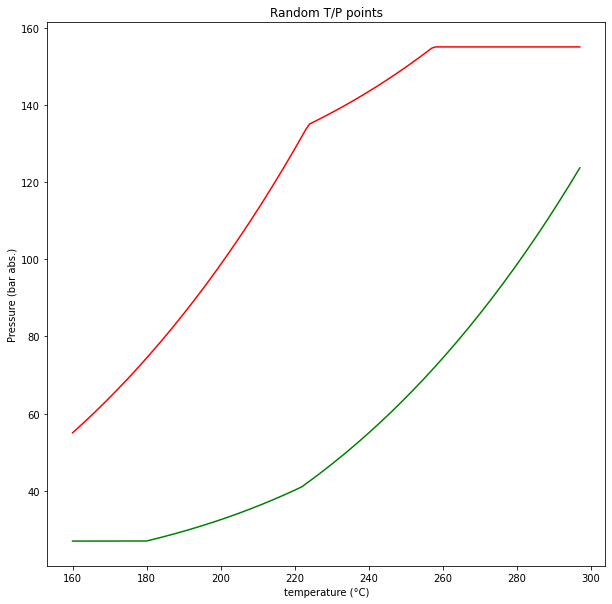

In [66]:
def angv_index(array):
    """
    Takes a numpy array and isolates all points that are within [10,160] for
    the first dimension and between [5,31] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] <= 297.2) & (array[:, 1] <= 155)
    return array[index]
    
angv_array = angv_index(quadrant_index(array)[1])

print('Points in quadrant II', len(quadrant_index(array)[1]))
print('Points in AN/GV domaine I', len(angv_array), ' ', 
      round(len(angv_array)/len(quadrant_index(array)[1]) * 100, 2), '%')

# Plot some data
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'red')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'green')
plt.show()

# Naive approach
We test all the point again the limits. It is mainly to obtain a computing time baseline.

AN/GV naive filter on the complet random array	56.1 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
AN/GV naive filter on ANGV domaine array	49.3 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


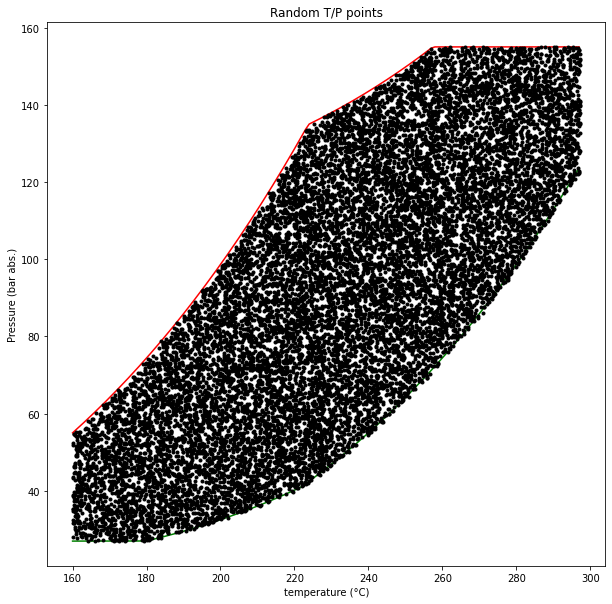

In [72]:
def naive_angv(array, upper_angv_limit, lower_angv_limit):
    """
    Boolean filter of the upper angv band
    lookup table, entry temperature rounded to +/- 1°c
    """
    temp = []
    for point in array:
        if point[1] < upper_angv_limit[int(point[0])-160][1] and point[1] > lower_angv_limit[int(point[0])-160][1]:
            temp.append(point)
            
    return np.array(temp)

#Performance indicator - remove if not needed - run the function 700 times.
print('AN/GV naive filter on the complet random array\t', end='')
%timeit naive_angv(angv_index(quadrant_index(array)[1]), upper_angv_limit, lower_angv_limit)

print('AN/GV naive filter on ANGV domaine array\t', end='')
%timeit naive_angv(angv_array, upper_angv_limit, lower_angv_limit)

angv_data = naive_angv(angv_index(quadrant_index(array)[1]), upper_angv_limit, lower_angv_limit)

# Plot the results 
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'red')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'green')
plt.plot(angv_data[:, 0], angv_data[:, 1],'k.')
plt.show()

Baseline: 
`AN/GV naive filter total	55.5 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
AN/GV naive filter ANGV domaine 	48.7 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)`

## Reduce the number of points, again


Upper line coef: (-99.97160525911697, 137.0, 8456.56676195774)
Lower line coef: (-96.68380360336262, 137.0, 11770.408576538019)


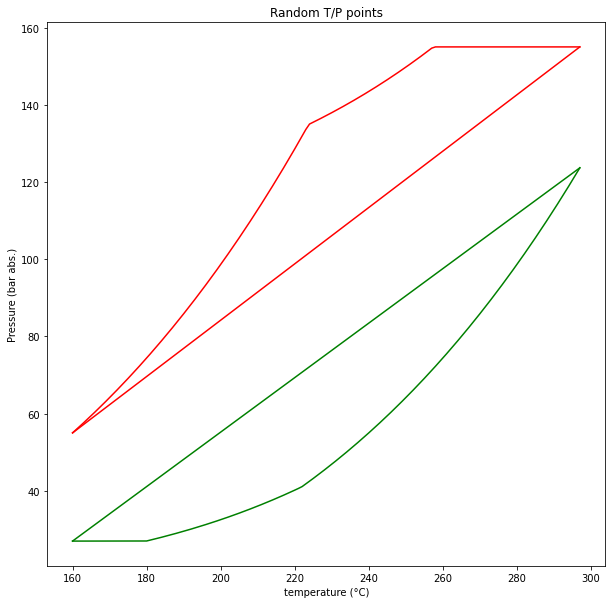

In [86]:
def line_from_point(point_a, point_b):
    """
    Cuts the AN/GV domain along its diagonal.
    Ax+By+C = 0
    (y1 – y2)x + (x2 – x1)y + (x1y2 – x2y1) = 0
    (160,31) - (297.2,155)    
    """
    coef_a = point_a[1] - point_b[1]
    coef_b = point_b[0] - point_a[0]
    coef_c = (point_a[0] * point_b[1]) - (point_b[0] * point_a[1])
    
    return (coef_a, coef_b, coef_c) 


print('Upper line coef:', line_from_point(upper_angv_limit[0], upper_angv_limit[-1]))
print('Lower line coef:', line_from_point(lower_angv_limit[0], lower_angv_limit[-1]))
upper_coef = line_from_point(upper_angv_limit[0], upper_angv_limit[-1])
lower_coef = line_from_point(lower_angv_limit[0], lower_angv_limit[-1])

import math 

def distance_to_line(angv_limit, coef_a, coef_b, coef_c):
    """
    distance = asb(ax_0+by_0+c)\sqrt(a^2+b^2)
    """
    distance = []
    for item in angv_limit:
        distance.append([int(item[0]), (coef_a * item[0] + coef_b * item[1] + coef_c)/ math.sqrt(coef_a ** 2 + coef_b **2)])     
    return np.array(distance)

upper_distance = distance_to_line(upper_angv_limit, upper_coef[0], upper_coef[1], upper_coef[2])
lower_distance = distance_to_line(lower_angv_limit, lower_coef[0], lower_coef[1], lower_coef[2])

# Plot the results 
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'red')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'green')
plt.plot(upper_angv_limit[(0,-1), 0], upper_angv_limit[(0,-1), 1], 'red')
plt.plot(lower_angv_limit[(0,-1), 0], lower_angv_limit[(0,-1), 1],'green')
plt.show()

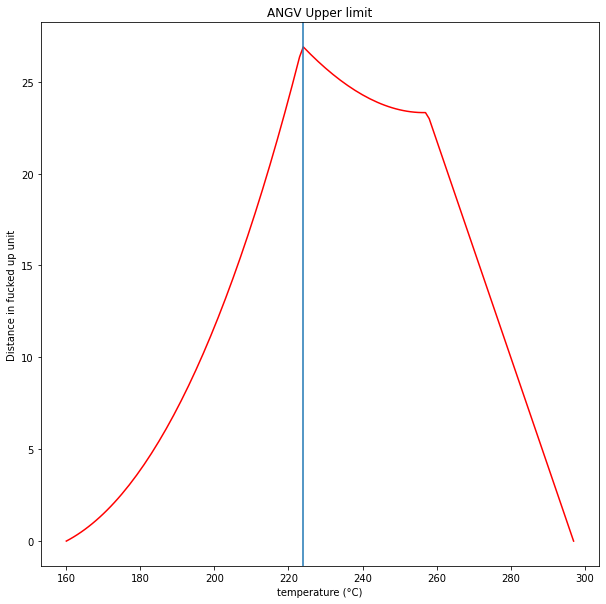

Most distant point : 26.89148997174471
[[224.          26.89148997]]


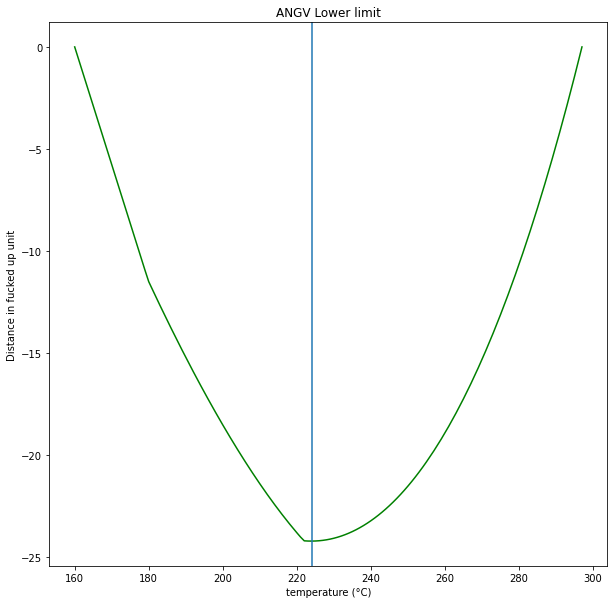

Most distant point : -24.225530042493702
[[224.         -24.22553004]]


In [114]:
plt.figure(figsize=(10, 10))
plt.title('ANGV Upper limit')
plt.xlabel('temperature (°C)')
plt.ylabel('Distance in fucked up unit')
plt.plot(upper_distance[:, 0], upper_distance[:, 1], 'red')
plt.axvline(224, 0, 28)
plt.show()

print('Most distant point :', np.max(upper_distance[:,1]))

print(upper_distance[np.where(upper_distance[:,1] == np.max(upper_distance[:,1]))])


plt.figure(figsize=(10, 10))
plt.title('ANGV Lower limit')
plt.xlabel('temperature (°C)')
plt.ylabel('Distance in fucked up unit')
plt.plot(lower_distance[:, 0], lower_distance[:, 1], 'green')
plt.axvline(224, 0, 28)
plt.show()

print('Most distant point :', np.min(lower_distance[:,1]))
print(lower_distance[np.where(lower_distance[:,1] == np.min(lower_distance[:,1]))])


In [ ]:
# Plot the results 
plt.figure(figsize=(10, 10))
plt.title('Random T/P points')
plt.xlabel('temperature (°C)')
plt.ylabel('Pressure (bar abs.)')
plt.plot(upper_angv_limit[:, 0], upper_angv_limit[:, 1], 'red')
plt.plot(lower_angv_limit[:, 0], lower_angv_limit[:, 1],'green')
plt.plot(297, 26.89148997)
plt.plot(160,-24.22553004)
plt.show()